In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
from helpers import *
from helpers import *
from plots import *
from plots import *
from split_data import *
from recommender import *
from cross_validation import *

%load_ext autoreload
%autoreload 2
np.seterr(all='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

## Load Data

In [3]:
path_dataset = "../data/data_train.csv"
ratings = load_data(path_dataset)

number of items: 10000, number of users: 1000


In [28]:
nnz_r,nnz_c = ratings.nonzero()

In [35]:
nz = list(zip(nnz_r, nnz_c))

In [36]:
under =0
up = 0
for d, n in nz:
    if ratings[d,n] > 5:
        up = up+1
    if ratings[d,n] < 1:
        under = under +1

In [37]:
under

0

In [38]:
up

0

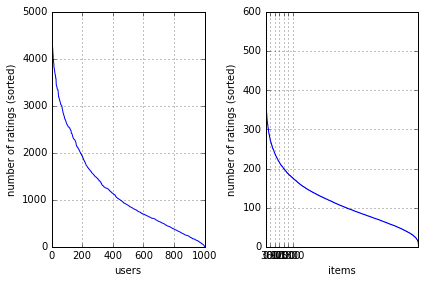

min # of items per user = 8, min # of users per item = 3.


In [4]:
num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

## Split data into training and test set

In [5]:
valid_ratings, train_validation, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
#plot_train_test_data(train_validation, test)

## Matrix factorisation using SGD

In [ ]:
%run run.py 0

## ALS

In [ ]:
%run run.py 1

## Other Methods
### CCD

In [35]:
%run run.py 2

Loading training data
number of items: 10000, number of users: 1000
Preprocessing data
Splitting data into train and test sets
Training model
learn the matrix factorization using CCD...
iter: 0.0, RMSE on training set: 1.093432775120109.
iter: 1.0, RMSE on training set: 1.0101849106969572.
iter: 2.0, RMSE on training set: 0.9913295912081788.
iter: 3.0, RMSE on training set: 0.9869897338042543.
iter: 4.0, RMSE on training set: 0.9859527104933422.
iter: 5.0, RMSE on training set: 0.9856933115214811.
iter: 6.0, RMSE on training set: 0.985624653358203.
RMSE on test data: 1.0058753685813262.
RMSE on train data: 0.985624653358203.
RMSE on test data: 1.0058753685813262.


### CCD++

In [45]:
%run run.py 3 --submit

Loading training data
number of items: 10000, number of users: 1000
Preprocessing data
Training model
Running 1th fold in 10 folds
learn the matrix factorization using CCD++...
iter: 0.0, RMSE on training set: 0.9903381028555411.
iter: 1.0, RMSE on training set: 0.9903381028555411.
RMSE on test data: 1.0006146604733976.
Running 2th fold in 10 folds
learn the matrix factorization using CCD++...
iter: 0.0, RMSE on training set: 0.9902355659276648.
iter: 1.0, RMSE on training set: 0.9902355659276648.
RMSE on test data: 1.001516435731386.
Running 3th fold in 10 folds
learn the matrix factorization using CCD++...
iter: 0.0, RMSE on training set: 0.990304070453025.
iter: 1.0, RMSE on training set: 0.990304070453025.
RMSE on test data: 1.0008886985480645.
Running 4th fold in 10 folds
learn the matrix factorization using CCD++...
iter: 0.0, RMSE on training set: 0.9904600070297657.
iter: 1.0, RMSE on training set: 0.9904600070297657.
RMSE on test data: 0.9996070655212942.
Running 5th fold in 1

## Cross validation

### Number of features

Running num_features=1
Running 1th fold in 10 folds
learn the matrix factorization using CCD++...
iter: 0.0, RMSE on training set: 0.9904900809435744.
iter: 1.0, RMSE on training set: 0.9904900809435744.
RMSE on test data: 1.0006430527407613.
Running 2th fold in 10 folds
learn the matrix factorization using CCD++...
iter: 0.0, RMSE on training set: 0.9903873201539922.
iter: 1.0, RMSE on training set: 0.9903873201539922.
RMSE on test data: 1.0015265151970847.
Running 3th fold in 10 folds
learn the matrix factorization using CCD++...
iter: 0.0, RMSE on training set: 0.9904558225938457.
iter: 1.0, RMSE on training set: 0.9904558225938457.
RMSE on test data: 1.0009699185394834.
Running 4th fold in 10 folds
learn the matrix factorization using CCD++...
iter: 0.0, RMSE on training set: 0.9906118679454422.
iter: 1.0, RMSE on training set: 0.9906118679454422.
RMSE on test data: 0.9997708187658811.
Running 5th fold in 10 folds
learn the matrix factorization using CCD++...
iter: 0.0, RMSE on tra

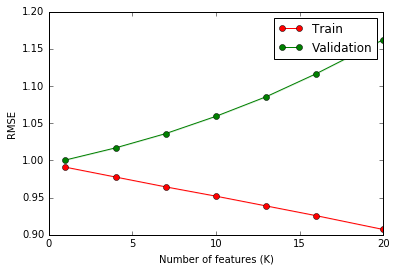

In [6]:
## !!! Takes long time to run

method = 3     # 0-SGD 1-ALS
K = 10         ## K-fold cross validation
gamma = 0.01
num_features_arr = [1, 4, 7, 10, 13, 16, 20]   # K in the lecture notes
lambda_user = 0.1
lambda_item = 0.7
min_num_ratings=10

train_rmse_mean = np.zeros(len(num_features_arr))
train_rmse_std = np.zeros(len(num_features_arr))
validation_rmse_mean = np.zeros(len(num_features_arr))
validation_rmse_std = np.zeros(len(num_features_arr))

for i, num_features in enumerate(num_features_arr):
    train_rmse_arr = []
    validation_rmse_arr = []
    
    print('Running num_features={n}'.format(n=num_features))
    [train_rmse_arr, validation_rmse_arr] = cross_validation_minimalist(ratings, method, K, num_features, lambda_user, lambda_item)
        
    ## Calculate mean and standard deviation    
    train_rmse_mean[i] = np.mean(train_rmse_arr)
    train_rmse_std[i] = np.std(train_rmse_arr)
    validation_rmse_mean[i] = np.mean(validation_rmse_arr)
    validation_rmse_std[i] = np.std(validation_rmse_std)
    
## Plotting results
plt.fill_between(num_features_arr, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(num_features_arr, validation_rmse_mean - validation_rmse_std,
                     validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
plt.plot(num_features_arr, train_rmse_mean, 'o-', color="r")
plt.plot(num_features_arr, validation_rmse_mean, 'o-', color="g")
plt.legend(('Train', 'Validation'))
plt.xlabel('Number of features (K)'); plt.ylabel('RMSE');
plt.show()

In [8]:
plt.savefig('ccdplus_CV_num_features.png');

In [11]:
import pandas as pd
tab = pd.DataFrame()
tab['numFeatures'] = num_features_arr;
tab['train RMSE mean'] = train_rmse_mean
tab['train RMSE std'] = train_rmse_std
tab['test RMSE mean'] = validation_rmse_mean
tab['test RMSE std'] = validation_rmse_std
tab.to_csv('ccdplus_CV_num_features.csv', sep = ',')


Running lambda_user=0.01
Running 1th fold in 10 folds
learn the matrix factorization using CCD++...
iter: 0.0, RMSE on training set: 0.9905120402314358.
iter: 1.0, RMSE on training set: 0.9905120402314358.
RMSE on test data: 1.0006561439583412.
Running 2th fold in 10 folds
learn the matrix factorization using CCD++...
iter: 0.0, RMSE on training set: 0.9904092461006758.
iter: 1.0, RMSE on training set: 0.9904092461006758.
RMSE on test data: 1.001538376604576.
Running 3th fold in 10 folds
learn the matrix factorization using CCD++...
iter: 0.0, RMSE on training set: 0.990477750872439.
iter: 1.0, RMSE on training set: 0.990477750872439.
RMSE on test data: 1.0009871106146258.
Running 4th fold in 10 folds
learn the matrix factorization using CCD++...
iter: 0.0, RMSE on training set: 0.990633808868161.
iter: 1.0, RMSE on training set: 0.990633808868161.
RMSE on test data: 0.9997944327774473.
Running 5th fold in 10 folds
learn the matrix factorization using CCD++...
iter: 0.0, RMSE on traini

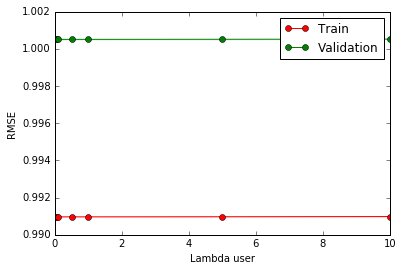

In [10]:
from cross_validation import *
## !!! Takes long time to run

method = 3     # 0-SGD 1-ALS
K = 10       ## K-fold cross validation
gamma = 0.01
num_features = 1   # K in the lecture notes
lambda_user_arr = [0.01, 0.05, 0.1, 0.5, 1, 5, 10]
lambda_item = 0.75
min_num_ratings=1

train_rmse_mean = np.zeros(len(lambda_user_arr))
train_rmse_std = np.zeros(len(lambda_user_arr))
validation_rmse_mean = np.zeros(len(lambda_user_arr))
validation_rmse_std = np.zeros(len(lambda_user_arr))

for i, lambda_user in enumerate(lambda_user_arr):
    
    print('Running lambda_user={n}'.format(n=lambda_user))
    [train_rmse_arr, validation_rmse_arr] = cross_validation_minimalist(ratings, method, K, num_features, lambda_user, lambda_item)
        
    train_rmse_mean[i] = np.mean(train_rmse_arr)
    train_rmse_std[i] = np.std(train_rmse_arr)
    validation_rmse_mean[i] = np.mean(validation_rmse_arr)
    validation_rmse_std[i] = np.std(validation_rmse_std)
    
## Plotting results
plt.fill_between(lambda_user_arr, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(lambda_user_arr, validation_rmse_mean - validation_rmse_std,
                     validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
plt.plot(lambda_user_arr, train_rmse_mean, 'o-', color="r")
plt.plot(lambda_user_arr, validation_rmse_mean, 'o-', color="g")
plt.legend(('Train', 'Validation'))
plt.xlabel('Lambda user'); plt.ylabel('RMSE');
plt.show()

In [12]:
plt.savefig('ccdplus_CV_lambda_user.png');
import pandas as pd
tab = pd.DataFrame()
tab['lambda user'] = lambda_user_arr;
tab['train RMSE mean'] = train_rmse_mean
tab['train RMSE std'] = train_rmse_std
tab['test RMSE mean'] = validation_rmse_mean
tab['test RMSE std'] = validation_rmse_std
tab.to_csv('ccdplus_CV_lambda_user.csv', sep = ',')

Running lambda_user=10
Running 1th fold in 10 folds
learn the matrix factorization using CCD++...
iter: 0.0, RMSE on training set: 0.9903460936707355.
iter: 1.0, RMSE on training set: 0.9903460936707355.
RMSE on test data: 1.0006444836431792.
Running 2th fold in 10 folds
learn the matrix factorization using CCD++...
iter: 0.0, RMSE on training set: 0.9902435834073589.
iter: 1.0, RMSE on training set: 0.9902435834073589.
RMSE on test data: 1.001530368698387.
Running 3th fold in 10 folds
learn the matrix factorization using CCD++...
iter: 0.0, RMSE on training set: 0.9903120665219117.
iter: 1.0, RMSE on training set: 0.9903120665219117.
RMSE on test data: 1.0008828779363521.
Running 4th fold in 10 folds
learn the matrix factorization using CCD++...
iter: 0.0, RMSE on training set: 0.9904680360622357.
iter: 1.0, RMSE on training set: 0.9904680360622357.
RMSE on test data: 0.9996035584468832.
Running 5th fold in 10 folds
learn the matrix factorization using CCD++...
iter: 0.0, RMSE on trai

TypeError: len() of unsized object

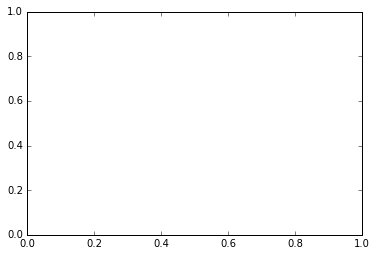

In [13]:
from cross_validation import *
## !!! Takes long time to run

method = 3     # 0-SGD 1-ALS
K = 10       ## K-fold cross validation
gamma = 0.01
num_features = 1   # K in the lecture notes
lambda_user_arr = 0.1
lambda_item_arr = [0.01, 0.05, 0.1, 0.5, 0.75, 1, 5, 10]
min_num_ratings=1

train_rmse_mean = np.zeros(len(lambda_item_arr))
train_rmse_std = np.zeros(len(lambda_item_arr))
validation_rmse_mean = np.zeros(len(lambda_item_arr))
validation_rmse_std = np.zeros(len(lambda_item_arr))

for i, lambda_item in enumerate(lambda_item_arr):
    
    print('Running lambda_user={n}'.format(n=lambda_user))
    [train_rmse_arr, validation_rmse_arr] = cross_validation_minimalist(ratings, method, K, num_features, lambda_user, lambda_item)
        
    train_rmse_mean[i] = np.mean(train_rmse_arr)
    train_rmse_std[i] = np.std(train_rmse_arr)
    validation_rmse_mean[i] = np.mean(validation_rmse_arr)
    validation_rmse_std[i] = np.std(validation_rmse_std)
    
## Plotting results
plt.fill_between(lambda_item_arr, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(lambda_item_arr, validation_rmse_mean - validation_rmse_std,
                     validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
plt.plot(lambda_item_arr, train_rmse_mean, 'o-', color="r")
plt.plot(lambda_item_arr, validation_rmse_mean, 'o-', color="g")
plt.legend(('Train', 'Validation'))
plt.xlabel('Lambda item'); plt.ylabel('RMSE');
plt.show()

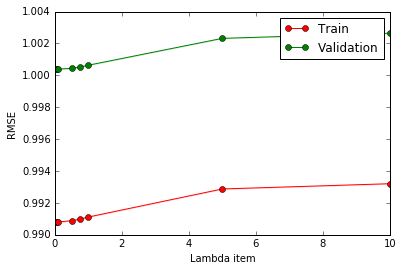

In [15]:
plt.fill_between(lambda_item_arr, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(lambda_item_arr, validation_rmse_mean - validation_rmse_std,
                     validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
plt.plot(lambda_item_arr, train_rmse_mean, 'o-', color="r")
plt.plot(lambda_item_arr, validation_rmse_mean, 'o-', color="g")
plt.legend(('Train', 'Validation'))
plt.xlabel('Lambda item'); plt.ylabel('RMSE');
plt.show()

In [16]:
plt.savefig('ccdplus_CV_lambda_item.png');
import pandas as pd
tab = pd.DataFrame()
tab['lambda item'] = lambda_item_arr;
tab['train RMSE mean'] = train_rmse_mean
tab['train RMSE std'] = train_rmse_std
tab['test RMSE mean'] = validation_rmse_mean
tab['test RMSE std'] = validation_rmse_std
tab.to_csv('ccdplus_CV_lambda_item.csv', sep = ',')

Running num_features=1
Running 1th fold in 5 folds
learn the matrix factorization using CCD...
iter: 0.0, RMSE on training set: 0.9964502496543466.
iter: 1.0, RMSE on training set: 0.9964502489575263.
RMSE on test data: 0.9964586489194359.
Running 2th fold in 5 folds
learn the matrix factorization using CCD...
iter: 0.0, RMSE on training set: 0.9964502496543466.
iter: 1.0, RMSE on training set: 0.9964502489575263.
RMSE on test data: 0.9964583524323956.
Running 3th fold in 5 folds
learn the matrix factorization using CCD...
iter: 0.0, RMSE on training set: 0.9964502496543466.
iter: 1.0, RMSE on training set: 0.9964502489575263.
RMSE on test data: 0.9964522566776196.
Running 4th fold in 5 folds
learn the matrix factorization using CCD...
iter: 0.0, RMSE on training set: 0.9964502496543466.
iter: 1.0, RMSE on training set: 0.9964502489575263.
RMSE on test data: 0.996441726997925.
Running 5th fold in 5 folds
learn the matrix factorization using CCD...
iter: 0.0, RMSE on training set: 0.996

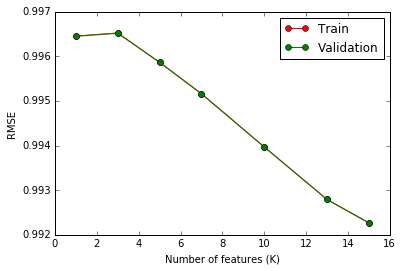

In [9]:
## !!! Takes long time to run

method = 2     # 0-SGD 1-ALS
K = 5         ## K-fold cross validation
gamma = 0.01
num_features_arr = [1, 3, 5, 7, 10, 13, 15]   # K in the lecture notes
lambda_user = 0.9
lambda_item = 0.1
min_num_ratings=10

train_rmse_mean = np.zeros(len(num_features_arr))
train_rmse_std = np.zeros(len(num_features_arr))
validation_rmse_mean = np.zeros(len(num_features_arr))
validation_rmse_std = np.zeros(len(num_features_arr))

for i, num_features in enumerate(num_features_arr):
    train_rmse_arr = []
    validation_rmse_arr = []
    
    print('Running num_features={n}'.format(n=num_features))
    [train_rmse_arr, validation_rmse_arr] = cross_validation_minimalist(ratings, method, K, num_features, lambda_user, lambda_item)
        
    ## Calculate mean and standard deviation    
    train_rmse_mean[i] = np.mean(train_rmse_arr)
    train_rmse_std[i] = np.std(train_rmse_arr)
    validation_rmse_mean[i] = np.mean(validation_rmse_arr)
    validation_rmse_std[i] = np.std(validation_rmse_std)
    
## Plotting results
plt.fill_between(num_features_arr, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(num_features_arr, validation_rmse_mean - validation_rmse_std,
                     validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
plt.plot(num_features_arr, train_rmse_mean, 'o-', color="r")
plt.plot(num_features_arr, validation_rmse_mean, 'o-', color="g")
plt.legend(('Train', 'Validation'))
plt.xlabel('Number of features (K)'); plt.ylabel('RMSE');
plt.show()

### lambda_user

In [ ]:
## !!! Takes long time to run

method = 2     # 0-SGD 1-ALS
K = 5        ## K-fold cross validation
gamma = 0.01
num_features = 4   # K in the lecture notes
lambda_user_arr = [0.5, 0.75, 1, 1.25, 1.5, 2]
lambda_item = 0.7
min_num_ratings=10

train_rmse_mean = np.zeros(len(lambda_user_arr))
train_rmse_std = np.zeros(len(lambda_user_arr))
validation_rmse_mean = np.zeros(len(lambda_user_arr))
validation_rmse_std = np.zeros(len(lambda_user_arr))

for i, lambda_user in enumerate(lambda_user_arr):
    train_rmse_arr = []
    validation_rmse_arr = []
    
    print('Running lambda_user={n}'.format(n=lambda_user))
    [train_rmse_arr, validation_rmse_arr] = cross_validation(ratings, K, method, num_items_per_user, 
                                                             num_users_per_item, min_num_ratings,  num_features, lambda_user, lambda_item)
        
    train_rmse_mean[i] = np.mean(train_rmse_arr)
    train_rmse_std[i] = np.std(train_rmse_arr)
    validation_rmse_mean[i] = np.mean(validation_rmse_arr)
    validation_rmse_std[i] = np.std(validation_rmse_std)
    
## Plotting results
plt.fill_between(lambda_user_arr, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(lambda_user_arr, validation_rmse_mean - validation_rmse_std,
                     validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
plt.plot(lambda_user_arr, train_rmse_mean, 'o-', color="r")
plt.plot(lambda_user_arr, validation_rmse_mean, 'o-', color="g")
plt.legend(('Train', 'Validation'))
plt.xlabel('Lambda user'); plt.ylabel('RMSE');
plt.show()

### Lambda item

In [ ]:
## !!! Takes long time to run

method = 2     # 0-SGD 1-ALS
K = 5        ## K-fold cross validation
gamma = 0.01
num_features = 5   # K in the lecture notes
lambda_user = 0.1
lambda_item_arr = [0.01, 0.1, 0.5, 1]
min_num_ratings=10

train_rmse_mean = np.zeros(len(lambda_item_arr))
train_rmse_std = np.zeros(len(lambda_item_arr))
validation_rmse_mean = np.zeros(len(lambda_item_arr))
validation_rmse_std = np.zeros(len(lambda_item_arr))

for i, lambda_item in enumerate(lambda_item_arr):
    train_rmse_arr = []
    validation_rmse_arr = []
    
    print('Running lambda_item={n}'.format(n=lambda_item))
    [train_rmse_arr, validation_rmse_arr] = cross_validation(ratings, K, method, num_items_per_user, 
                                                             num_users_per_item, min_num_ratings,  num_features, lambda_user, lambda_item)
        
    train_rmse_mean[i] = np.mean(train_rmse_arr)
    train_rmse_std[i] = np.std(train_rmse_arr)
    validation_rmse_mean[i] = np.mean(validation_rmse_arr)
    validation_rmse_std[i] = np.std(validation_rmse_std)
    
## Plotting results
plt.fill_between(lambda_item_arr, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(lambda_item_arr, validation_rmse_mean - validation_rmse_std,
                     validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
plt.plot(lambda_item_arr, train_rmse_mean, 'o-', color="r")
plt.plot(lambda_item_arr, validation_rmse_mean, 'o-', color="g")
plt.legend(('Train', 'Validation'))
plt.xlabel('Lambda item'); plt.ylabel('RMSE');
plt.show()

### Learning rate

In [ ]:
## !!! Takes long time to run

method = 0     # 0-SGD
K = 10        ## K-fold cross validation
gamma_arr = [0.01, 0.1, 1]
num_features = 20   # K in the lecture notes
lambda_user = 0.1
lambda_item = 0.5

train_rmse_mean = np.zeros(len(gamma_arr))
train_rmse_std = np.zeros(len(gamma_arr))
validation_rmse_mean = np.zeros(len(gamma_arr))
validation_rmse_std = np.zeros(len(gamma_arr))

for i, gamma in enumerate(gamma_arr):
    train_rmse_arr = []
    validation_rmse_arr = []
    
    print('Running gamma={n}'.format(n=gamma))
    [train_rmse_arr, validation_rmse_arr] = cross_validation(ratings, K, method, num_items_per_user, 
                                                             num_users_per_item, min_num_ratings=10)
        
    train_rmse_mean[i] = np.mean(train_rmse_arr)
    train_rmse_std[i] = np.std(train_rmse_arr)
    validation_rmse_mean[i] = np.mean(validation_rmse_arr)
    validation_rmse_std[i] = np.std(validation_rmse_std)
    
## Plotting results
plt.fill_between(gamma_arr, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(gamma_arr, validation_rmse_mean - validation_rmse_std,
                     validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
plt.plot(gamma_arr, train_rmse_mean, 'o-', color="r")
plt.plot(gamma_arr, validation_rmse_mean, 'o-', color="g")
plt.legend(('Train', 'Validation'))
plt.xlabel('Learning Rate'); plt.ylabel('RMSE');
plt.show()

### TODO
#### 1. Compare SGD, ALS with the best set of parameters (based on above results)